## Reading Data from HDFS

Datasource: Semantic Scholar Open Research Corpus

Description: Semantic Scholar's records for research papers published in all fields provided as an easy-to-use JSON archive.

### Attribute Definitions
1. id  string = S2 generated research paper ID.
- title  string = Research paper title.
- paperAbstract  string = Extracted abstract of the paper.
- entities  list = Extracted list of relevant entities or topics.
- s2Url  string = URL to S2 research paper details page.
- s2PdfUrl  string = URL to PDF on S2 if available.
- pdfUrls  list = URLs related to this PDF scraped from the web.
- authors  list = List of authors with an S2 generated author ID and name.
- inCitations  list = List of S2 paper IDs which cited this paper.
- outCitations  list = List of S2 paper IDs which this paper cited
- year  int = Year this paper was published as integer.
- venue  string = Extracted publication venue for this paper.
- journalName  string = Name of the journal that published this paper.
- journalVolume  string = The volume of the journal where this paper was published.
- journalPages  string = The pages of the journal where this paper was published.
- sources  list = Identifies papers sourced from DBLP or Medline.
- doi  string = Digital Object Identifier registered at doi.org.
- doiUrl  string = DOI link for registered objects.
- pmid  string = Unique identifier used by PubMed.
- fieldsOfStudy  list = Zero or more fields of study this paper addresses.`

In [1]:
import pandas as pd 
import json
import matplotlib.pyplot as plt 

#Graph network imports
from graphframes import *
from pyspark import *
from pyspark.sql import *

In [2]:
#import statements
from pyspark.sql import SparkSession

spark = SparkSession.builder.enableHiveSupport().appName('ReadWriteData').getOrCreate()
sc = spark.sparkContext

In [3]:
!hdfs dfs -ls big_data_project/unzipped_files/

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Found 10 items
-rw-r--r--   3 nazihkalo nazihkalo 1592749572 2020-02-11 10:25 big_data_project/unzipped_files/s2-corpus-000
-rw-r--r--   3 nazihkalo nazihkalo 1592820732 2020-02-11 10:24 big_data_project/unzipped_files/s2-corpus-001
-rw-r--r--   3 nazihkalo nazihkalo 1595233436 2020-02-11 10:24 big_data_project/unzipped_files/s2-corpus-002
-rw-r--r--   3 nazihkalo nazihkalo 1597066383 2020-02-11 10:24 big_data_project/unzipped_files/s2-corpus-003
-rw-r--r--   3 nazihkalo nazihkalo 1601510198 2020-02-11 10:24 big_data_project/unzipped_files/s2-corpus-004
-rw-r--r--   3 nazihkalo nazihkalo 1593588156 2020-02-11 10:25 big_data_project/unzipped_files/s2-corpus-005
-rw-r--r--   3 nazihkalo nazihkalo 1596634329 2020-02-11 10:23 big_data_project/unzipped_files/s2-corpus-006
-rw-r--r--   3 nazihkalo nazihkalo 1596512143 2020-02-11 10:25 big_data_project/unzipped_files/s2-corpus-007
-rw-r--r-

In [4]:
sc.environment

{'MKL_NUM_THREADS': '1', 'OPENBLAS_NUM_THREADS': '1', 'PYTHONHASHSEED': '0'}

## Reading all 10 json files listed above 

In [11]:
spark_df = spark.read.json('big_data_project/unzipped_files/')

#### Counting number of records/articles

In [12]:
spark_df.count()

9976989

#### Looking at the schema & summary stats

In [13]:
spark_df.printSchema()

root
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- ids: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- doiUrl: string (nullable = true)
 |-- entities: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- fieldsOfStudy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- inCitations: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- journalName: string (nullable = true)
 |-- journalPages: string (nullable = true)
 |-- journalVolume: string (nullable = true)
 |-- outCitations: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- paperAbstract: string (nullable = true)
 |-- pdfUrls: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- pmid: string (nullable = t

In [14]:
spark_df.dtypes

[('authors', 'array<struct<ids:array<string>,name:string>>'),
 ('doi', 'string'),
 ('doiUrl', 'string'),
 ('entities', 'array<string>'),
 ('fieldsOfStudy', 'array<string>'),
 ('id', 'string'),
 ('inCitations', 'array<string>'),
 ('journalName', 'string'),
 ('journalPages', 'string'),
 ('journalVolume', 'string'),
 ('outCitations', 'array<string>'),
 ('paperAbstract', 'string'),
 ('pdfUrls', 'array<string>'),
 ('pmid', 'string'),
 ('s2PdfUrl', 'string'),
 ('s2Url', 'string'),
 ('sources', 'array<string>'),
 ('title', 'string'),
 ('venue', 'string'),
 ('year', 'bigint')]

In [15]:
# spark_df.summary()

### Checking if any NaN rows 

In [52]:
#Calculating total number of NAN rows
row_count = spark_df.count()
null_row_count = row_count - spark_df.dropna().count()
print("Total Null rows = ", null_row_count)
print("Nulls as pct of total = {}%".format(round((null_row_count/row_count)*100, 2)))

Total Null rows =  192481
Nulls as pct of total = 1.93%


In [55]:
spark_df.select('fieldsOfStudy').distinct().count()

2180

In [56]:
spark_df.groupby('fieldsOfStudy').count().sort("count").orderBy(["count"], ascending=[0]).show(20)

+-------------------+-------+
|      fieldsOfStudy|  count|
+-------------------+-------+
|         [Medicine]|1797410|
|                 []|1270796|
|        [Chemistry]| 647360|
| [Computer Science]| 605115|
|      [Engineering]| 532338|
|          [Biology]| 493352|
|          [Physics]| 456051|
|[Materials Science]| 427580|
|       [Psychology]| 354488|
|          [History]| 312121|
|        [Sociology]| 299245|
|              [Art]| 292479|
|      [Mathematics]| 269465|
|[Political Science]| 268942|
|        [Geography]| 250747|
|        [Economics]| 198698|
|[Medicine, Biology]| 189729|
|         [Business]| 184848|
|[Biology, Medicine]| 170081|
|          [Geology]| 166235|
+-------------------+-------+
only showing top 20 rows



In [57]:
spark_df.select('year').distinct().count()

86

## Creating column that counts the inCitations = how many times this paper was cited

In [16]:
from pyspark.sql.functions import udf #user defined function
from pyspark.sql.types import * #Import types == IntegerType, StringType etc.

length = udf(lambda listt: len(listt), IntegerType())

In [17]:
spark_df2 = spark_df.withColumn('inCitations_count', length(spark_df['inCitations']))

In [18]:
spark_df2.select('inCitations_count', 'inCitations').show(10)

+-----------------+--------------------+
|inCitations_count|         inCitations|
+-----------------+--------------------+
|                0|                  []|
|                0|                  []|
|                0|                  []|
|               13|[8ecaab2a03953fa5...|
|                0|                  []|
|                0|                  []|
|                0|                  []|
|                0|                  []|
|               22|[ecec08f5ca15e07d...|
|                2|[2da3df885d1f032d...|
+-----------------+--------------------+
only showing top 10 rows



## Creating column that counts the outCitations = how many other papers this paper cited

In [19]:
spark_df2 = spark_df2.withColumn('outCitations_count', length(spark_df2['outCitations']))
spark_df2.select('outCitations_count', 'outCitations').show(10)

+------------------+--------------------+
|outCitations_count|        outCitations|
+------------------+--------------------+
|                 0|                  []|
|                 0|                  []|
|                 0|                  []|
|                69|[cf5cdba6424524ee...|
|                 0|                  []|
|                 0|                  []|
|                 0|                  []|
|                 0|                  []|
|                 0|                  []|
|                 0|                  []|
+------------------+--------------------+
only showing top 10 rows



## Creating column that for length of abstract

In [128]:
spark_df2.select('paperAbstract').show(1, truncate = False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|paperAbstract                                                                                                                                                                                                                                                                                                 

In [35]:
# # Construction 2
# from spacy.lang.en import English
# nlp = English()
# # Create a Tokenizer with the default settings for English
# # including punctuation rules and exceptions
# tokenizer = nlp.Defaults.create_tokenizer(nlp)

In [20]:
import nltk

In [21]:
word_count = udf(lambda string: len(nltk.word_tokenize(string)), IntegerType())

spark_df2 = spark_df2.withColumn('paperAbstract_wcount', word_count(spark_df2['paperAbstract']))

In [22]:
spark_df2.select('paperAbstract_wcount', 'paperAbstract').show(10)

+--------------------+--------------------+
|paperAbstract_wcount|       paperAbstract|
+--------------------+--------------------+
|                 113|The problem of bu...|
|                   0|                    |
|                 393|Aims and objectiv...|
|                 258|The mitogen-activ...|
|                   0|                    |
|                   0|                    |
|                   0|                    |
|                 167|O lexico desperta...|
|                 156|Ternary nano-bioc...|
|                 273|BACKGROUND AND AI...|
+--------------------+--------------------+
only showing top 10 rows



In [23]:
spark_df2 = spark_df2.withColumn('title_wcount', word_count(spark_df2['title']))
spark_df2.select('title_wcount', 'title').show(10)

+------------+--------------------------------+
|title_wcount|                           title|
+------------+--------------------------------+
|          12|            Cause Analysis an...|
|          21|            Clair comme lune ...|
|          15|            Unexpected deaths...|
|          12|            RNA-Seq Analysis ...|
|          15|            Temporal Trends a...|
|           4|激動期における企業とqc-2-消費...|
|          12|            Application of th...|
|           8|            A constituição do...|
|          11|            Nano-biocomposite...|
|          13|            Feasibility of tw...|
+------------+--------------------------------+
only showing top 10 rows



## Fixing some dtypes


In [24]:
spark_df2.dtypes

[('authors', 'array<struct<ids:array<string>,name:string>>'),
 ('doi', 'string'),
 ('doiUrl', 'string'),
 ('entities', 'array<string>'),
 ('fieldsOfStudy', 'array<string>'),
 ('id', 'string'),
 ('inCitations', 'array<string>'),
 ('journalName', 'string'),
 ('journalPages', 'string'),
 ('journalVolume', 'string'),
 ('outCitations', 'array<string>'),
 ('paperAbstract', 'string'),
 ('pdfUrls', 'array<string>'),
 ('pmid', 'string'),
 ('s2PdfUrl', 'string'),
 ('s2Url', 'string'),
 ('sources', 'array<string>'),
 ('title', 'string'),
 ('venue', 'string'),
 ('year', 'bigint'),
 ('inCitations_count', 'int'),
 ('outCitations_count', 'int'),
 ('paperAbstract_wcount', 'int'),
 ('title_wcount', 'int')]

In [25]:
import pyspark.sql.functions as F
spark_df2 = spark_df2.withColumn('author_ids', F.col('authors.ids'))
spark_df2 = spark_df2.withColumn('author_names', F.col('authors.name'))

#### Dropping 'authors', 'outCitations' & 'inCitations'  in favor of author_ids, author_names, & the counts of these citations 

In [26]:
spark_df3 = spark_df2.drop('authors') ### ONLY DROPPING AUTHORS SINCE WILL BE USING CITATIONS FORGRAPH

In [152]:
# spark_df3 = spark_df2.drop('authors', 'outCitations', 'inCitations')

#### Entities is empty so let's drop it 

In [27]:
spark_df3.select('entities').distinct().count()

1

In [28]:
spark_df3 = spark_df3.drop('entities')

In [167]:
spark_df3.select('inCitations_count', 'outCitations_count', 'paperAbstract_wcount', 'title_wcount').describe()

DataFrame[summary: string, inCitations_count: string, outCitations_count: string, paperAbstract_wcount: string, title_wcount: string]

### Now let's unpack the arrays and turn them into strings

In [29]:
#Defining function to unpack list intro string joined with ', ' 
udf_unpack = udf(lambda listt: ', '.join(listt), StringType())

In [30]:
spark_df3 = spark_df3.withColumn('fieldsOfStudy', udf_unpack(spark_df3['fieldsOfStudy']))

### SOURCES COLUMN from array to string

In [169]:
spark_df3.select('sources').distinct().count()

5

In [31]:
spark_df3 = spark_df3.withColumn('sources', udf_unpack(spark_df3['sources']))

In [32]:
spark_df3 = spark_df3.withColumn('pdfUrls', udf_unpack(spark_df3['pdfUrls']))

In [33]:
spark_df3.printSchema()

root
 |-- doi: string (nullable = true)
 |-- doiUrl: string (nullable = true)
 |-- fieldsOfStudy: string (nullable = true)
 |-- id: string (nullable = true)
 |-- inCitations: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- journalName: string (nullable = true)
 |-- journalPages: string (nullable = true)
 |-- journalVolume: string (nullable = true)
 |-- outCitations: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- paperAbstract: string (nullable = true)
 |-- pdfUrls: string (nullable = true)
 |-- pmid: string (nullable = true)
 |-- s2PdfUrl: string (nullable = true)
 |-- s2Url: string (nullable = true)
 |-- sources: string (nullable = true)
 |-- title: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- year: long (nullable = true)
 |-- inCitations_count: integer (nullable = true)
 |-- outCitations_count: integer (nullable = true)
 |-- paperAbstract_wcount: integer (nullable = true)
 |-- title_wcount: integer (null

### Creating Vertices

In [43]:
vertices = spark_df3.select('id', 'title', 'year', 'fieldsOfStudy', 'paperAbstract')

In [59]:
vertices.show(5)

+--------------------+--------------------+----+-----------------+--------------------+
|                  id|               title|year|    fieldsOfStudy|       paperAbstract|
+--------------------+--------------------+----+-----------------+--------------------+
|b9c27ac1bb8b3ec9d...|Cause Analysis an...|2014|         Business|The problem of bu...|
|91cac7b12800a6238...|Clair comme lune ...|2016|          History|                    |
|412b10a92babf3509...|Unexpected deaths...|2013|         Medicine|Aims and objectiv...|
|0de1cecd2ed49812f...|RNA-Seq Analysis ...|2015|Medicine, Biology|The mitogen-activ...|
|1d9fee40f59bf00eb...|Temporal Trends a...|2012|         Medicine|                    |
+--------------------+--------------------+----+-----------------+--------------------+
only showing top 5 rows



### Creating Edges

In [51]:
from pyspark.sql.functions import explode
from pyspark.sql.functions import lit

#Getting the inCitations id -> (cited) -> article id 
edges = spark_df3.select(explode('inCitations').alias('src'), spark_df3.id.alias('dst')).withColumn('type', lit('cited'))

#Getting the article id -> (cited) -> outCitations id
edges2 = spark_df3.select(spark_df3.id.alias('src'), explode('outCitations').alias('dst')).withColumn('type', lit('cited'))

#Union of these two 
edges_total = edges.union(edges2)

In [57]:
edges_total.show(5, truncate=False)

+----------------------------------------+----------------------------------------+-----+
|src                                     |dst                                     |type |
+----------------------------------------+----------------------------------------+-----+
|8ecaab2a03953fa5cf08ab5db2bb49c16d90527d|0de1cecd2ed49812f3a55e4b78edf9ffd292618c|cited|
|8ea68d48d5595730f082f625a2ad759f934411cf|0de1cecd2ed49812f3a55e4b78edf9ffd292618c|cited|
|766a2b4d54b541c737f6a6ec81ad487b56dc83ed|0de1cecd2ed49812f3a55e4b78edf9ffd292618c|cited|
|8479962401362c07f2d6cbff871a11cbd7a4913f|0de1cecd2ed49812f3a55e4b78edf9ffd292618c|cited|
|a0ab0cf6c8fe0b1e50407576ba5b80f0f3f58476|0de1cecd2ed49812f3a55e4b78edf9ffd292618c|cited|
+----------------------------------------+----------------------------------------+-----+
only showing top 5 rows



In [60]:
g = GraphFrame(vertices, edges_total)
## Take a look at the DataFrames
# g.vertices.show()
# g.edges.show()
## Check the number of edges of each vertex
g.degrees.show()

+--------------------+------+
|                  id|degree|
+--------------------+------+
|0527b65da84f42a39...|    28|
|a830e94246ea34694...|    12|
|61fa386d2187bebaf...|     6|
|4bebbb2592590a23c...|     1|
|ff6007e947ed35055...|     5|
|16d5358ed974cdefc...|     2|
|ba562608abe6a7e81...|     1|
|19f599b95b54304ec...|    21|
|5e5ce011e6f57a24d...|     1|
|6ccc8a7f7c1362cb9...|     2|
|5c8faef8512d3ac63...|     6|
|932a7e026b2acd162...|    20|
|ca82c02aef19b1e64...|    40|
|7d306abf7ff739313...|     8|
|d23cb008042ae46a8...|    63|
|dc19d325198236660...|    67|
|56f289078d090d0ea...|     2|
|2227a64a2d770f06d...|    29|
|3c0b62bc2d1d09a0c...|     7|
|6e1516a2c25889ffd...|     3|
+--------------------+------+
only showing top 20 rows



#### indegree = The number of edges directed into a vertex in a directed graph.

In [61]:
g.inDegrees.filter("inDegree >= 10").sort("inDegree", ascending=False).show()

+--------------------+--------+
|                  id|inDegree|
+--------------------+--------+
|83730969c0686b1d1...|   38079|
|abd1c342495432171...|   32420|
|13d4c2f76a7c1a4d0...|   20763|
|a512385be058b1e2e...|   17634|
|a411f6a0e6473137a...|   17370|
|87f40e6f3022adbc1...|   12898|
|73679f1ba00de9e73...|   11428|
|e6dd0e6cf076b1207...|   11276|
|d2860a370a0386c57...|   10815|
|6a17ebeeb80cd696b...|    9429|
|6da2a9ffa23a59523...|    9197|
|10d6778bc45aebcd5...|    9120|
|490020c0d4fa1eb85...|    9028|
|fc448a7db5a2fac24...|    8676|
|54205667c1f65a320...|    8611|
|cc90910b6e31fe44c...|    8231|
|a42d6065d0b1a31c5...|    8182|
|6889e5a22598521d8...|    7656|
|0e68beebb4c7ccbd9...|    7486|
|9f649b234f5ebf207...|    7350|
+--------------------+--------+
only showing top 20 rows



In [62]:
g.inDegrees.filter("inDegree >= 10").sort("inDegree", ascending=False).select('id').take(1)

[Row(id='83730969c0686b1d185bcca39f9b5743fa53ebc1')]

In [65]:
g.vertices.filter('id == "83730969c0686b1d185bcca39f9b5743fa53ebc1"').show(truncate = False)

+----------------------------------------+--------------------------------------------------------+----+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id                                      |title                                                   |year|fieldsOfStudy   |paperAbstract                               

## Journal Name

In [170]:
spark_df3.select('journalName').distinct().count()

50554

In [148]:
# from pyspark.sql.functions import explode
# id_authors = spark_df2.select(explode('author_ids'))
# spark_df2.select('author_names', explode('author_names')).show()

In [86]:
# #Convert the list + string into string
# spark_df3 = spark_df3.withColumn("entities", spark_df3["entities"].cast(StringType()))
# spark_df3 = spark_df3.withColumn("fieldsOfStudy", spark_df3["fieldsOfStudy"].cast(StringType()))
# spark_df3 = spark_df3.withColumn("pdfUrls", spark_df3["pdfUrls"].cast(StringType()))
# spark_df3 = spark_df3.withColumn("sources", spark_df3["sources"].cast(StringType()))

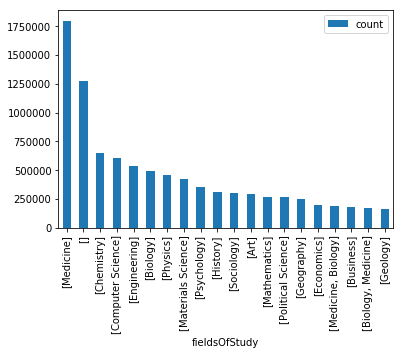

In [155]:
fields_count = spark_df3.groupby('fieldsOfStudy').count().sort('count', ascending = False)
#convert Pyspark dataframe to Pandas dataframe for plotting
pdf = fields_count.toPandas()
pdf[:20].plot(kind= 'bar', x='fieldsOfStudy')
plt.show()

#### Nans by column

In [171]:
# from pyspark.sql.functions import isnan, when, count, col

# spark_df3.select([count(when(isnan(c), c)).alias(c) for c in spark_df3.columns]).show()

# DISTRIBUTION OF inCitations_count

In [176]:
import pandas as pd
import matplotlib.pyplot as plt

# Doing the heavy lifting in Spark. We could leverage the `histogram` function from the RDD api

inCitations_count_histogram = spark_df3.select('inCitations_count').rdd.flatMap(lambda x: x).histogram(11)

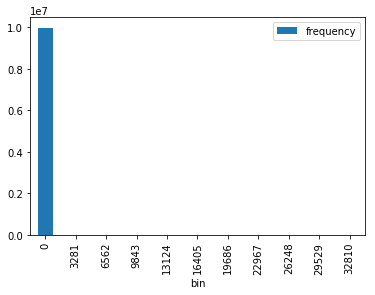

In [175]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*inCitations_count_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar')

In [188]:
from pyspark.sql import functions as F

spark_df3.agg(F.min(spark_df3.inCitations_count),F.max(spark_df3.inCitations_count), \
              F.avg(spark_df3.inCitations_count),F.sum(spark_df3.inCitations_count), \
             F.count(spark_df3.inCitations_count)).show(truncate = False)

+----------------------+----------------------+----------------------+----------------------+------------------------+
|min(inCitations_count)|max(inCitations_count)|avg(inCitations_count)|sum(inCitations_count)|count(inCitations_count)|
+----------------------+----------------------+----------------------+----------------------+------------------------+
|0                     |36091                 |3.5324064204140146    |35242780              |9976989                 |
+----------------------+----------------------+----------------------+----------------------+------------------------+



In [189]:
spark_df3.count()

9976989

In [190]:
spark_df3.write.csv('corpus0_to_9.csv')

AnalysisException: 'CSV data source does not support array<string> data type.;'

In [174]:
# spark_df4.write.format('parquet').save('all_papers_csv')

# HIVE

In [14]:
from pyspark.sql import HiveContext
hive_context = HiveContext(sc)

In [15]:
#show databaes
spark.sql('show databases').show()

+-------------+
| databaseName|
+-------------+
|     aamorris|
|    ababikova|
|          abb|
|      abertin|
| abhishekchat|
|      achenad|
|  adeshghadge|
|      adetola|
| adhamsuliman|
|   aditilakra|
|       aghose|
|       ahphan|
|      airline|
|       alphan|
|       aluong|
|alvinharyanto|
|       amant3|
|    amiparikh|
|amoliterno945|
|     andmoral|
+-------------+
only showing top 20 rows

